This notebook shows how to use [CDD](https://www.inf.ethz.ch/personal/fukudak/cdd_home/) to compute controlled invariant sets for an hybrid system.

In [24]:
using Pkg
pkg"add CDDLib"

 Resolving package versions...
 Installed CDDLib ─ v0.6.0
  Updating `~/.julia/dev/Polyhedra/examples/Project.toml`
  [3391f64e] + CDDLib v0.6.0
  Updating `~/.julia/dev/Polyhedra/examples/Manifest.toml`
  [3391f64e] + CDDLib v0.6.0
  Building CDDLib → `~/.julia/packages/CDDLib/UOZHh/deps/build.log`


In [32]:
using MathematicalSystems
using Polyhedra
function liftu(S, sys::LinearControlDiscreteSystem)
    [sys.A sys.B] \ S
end
function new_constraint(sys::LinearControlDiscreteSystem, S)
    ABset = liftu(S, sys)
    project(ABset, 1:statedim(sys))
end
function add_hrep!(S, h::HalfSpace)
    # I was using LP cycling errors when using CDD's LP solver
    if issubset(S, h) # If S ⊆ h, then adding h will not change affect S
        false
    else
        intersect!(S, h)
        true
    end
end
function add_constraint!(S, P)
    added = count(map(h -> add_hrep!(S, h), hyperplanes(P))) + count(map(h -> add_hrep!(S, h), halfspaces(P)))
    removehredundancy!(S) # CDD throws LP cycling error
    added
end
function set_iteration!(S, sys::LinearControlDiscreteSystem)
    Ps = new_constraint(sys, S)
    added = add_constraint!(S, Ps)
    @show added
end
function iterate!(S, sys, nit)
    map(i -> (gc(); @elapsed set_iteration!(S, sys)), 1:nit)
end

iterate! (generic function with 1 method)

In [80]:
using LinearAlgebra
Δt = 0.5
k = 1.0
c = 0.0
A = [I zeros(2, 1); zeros(1, 3)] + Δt * [0 1 0; -k -c 1; 0 0 0]
B = reshape([0.0, 0.0, 1.0], 3, 1)
sys = LinearControlDiscreteSystem(A, B)

LinearControlDiscreteSystem{Float64,Array{Float64,2},Array{Float64,2}}([1.0 0.5 0.0; -0.5 1.0 0.5; 0.0 0.0 0.0], [0.0; 0.0; 1.0])

In [66]:
interval = HalfSpace([1.0], 1.0) ∩ HalfSpace([-1.0], 1.0)

H-representation Polyhedra.Intersection{Float64,Array{Float64,1},Int64}:
2-element iterator of HalfSpace{Float64,Array{Float64,1}}:
 HalfSpace([1.0], 1.0)
 HalfSpace([-1.0], 1.0)

In [67]:
X = interval * interval * interval

H-representation Polyhedra.Intersection{Float64,Array{Float64,1},Int64}:
6-element iterator of HalfSpace{Float64,Array{Float64,1}}:
 HalfSpace([1.0, 0.0, 0.0], 1.0)
 HalfSpace([-1.0, 0.0, 0.0], 1.0)
 HalfSpace([0.0, 1.0, 0.0], 1.0)
 HalfSpace([0.0, -1.0, 0.0], 1.0)
 HalfSpace([0.0, 0.0, 1.0], 1.0)
 HalfSpace([0.0, 0.0, -1.0], 1.0)

In [81]:
using CDDLib
p = polyhedron(X, CDDLib.Library())

Polyhedron CDDLib.Polyhedron{Float64}:
6-element iterator of HalfSpace{Float64,Array{Float64,1}}:
 HalfSpace([1.0, 0.0, 0.0], 1.0)
 HalfSpace([-1.0, 0.0, 0.0], 1.0)
 HalfSpace([0.0, 1.0, 0.0], 1.0)
 HalfSpace([0.0, -1.0, 0.0], 1.0)
 HalfSpace([0.0, 0.0, 1.0], 1.0)
 HalfSpace([0.0, 0.0, -1.0], 1.0)

In [85]:
set_iteration!(p, sys)

added = 0


0

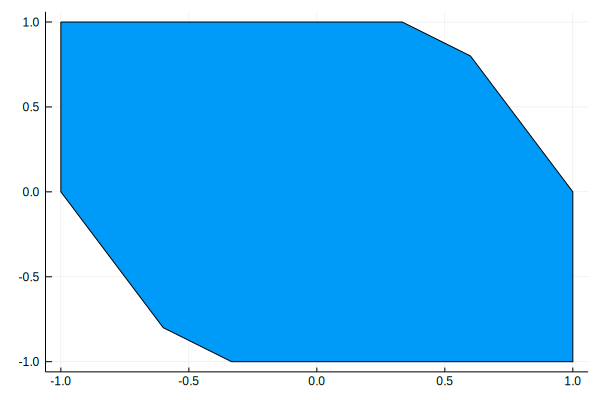

In [89]:
using Plots
vrep(p)
plot(project(p, [1,2]))

We consider the `cruise_control.jl` example of HybridSystems.jl which comes from [this paper](https://dl.acm.org/citation.cfm?id=2461378).

In [ ]:
include(Pkg.dir("HybridSystems", "examples", "cruise_control.jl"));

In [ ]:
const va = 15.6
const vb = 24.5
const vc = 29.5
const v = (va, vb, vc)
const U = 4.
const m0 = 500
const T = 2
const N = 10
const M = 1
const H = 0.8;

In [ ]:
function liftu(S, sys::HybridSystems.DiscreteLinearControlSystem)
    [sys.A sys.B] \ S
end
function new_constraint(hs, S, q, t)
    @assert source(hs, t) == q
    σ = symbol(hs, t)
    r = target(hs, t)
    ABset = liftu(S[1], hs.resetmaps[σ])
    project(ABset, 1:statedim(hs, q))
end
function new_constraints(hs, S, q)
    map(t -> new_constraint(hs, S, q, t), out_transitions(hs, q))
end
function add_hrep!(S, h::HalfSpace)
    # I was using LP cycling errors when using CDD's LP solver
    if issubset(S, h) # If S ⊆ h, then adding h will not change affect S
        false
    else
        push!(S, SimpleHRepresentation(reshape(h.a, 1, length(h.a)), [h.β]))
        true
    end
end
function add_constraint!(S, P)
    added = count(map(h -> add_hrep!(S, h), ineqs(P))) + count(map(h -> add_hrep!(S, h), eqs(P)))
    removehredundancy!(S) # CDD throws LP cycling error
    added
end
function add_constraints!(S::Polyhedron, Ps::Vector{<:Polyhedron})
    sum(P -> add_constraint!(S, P), Ps)
end
function set_iteration!(hs, S)
    Ps = map(q -> new_constraints(hs, S, q), states(hs))
    added = add_constraints!.(S, Ps)
    @show added
end
function iterate!(hs, S, nit)
    map(i -> (gc(); @elapsed set_iteration!(hs, S)), 1:nit)
end

In [ ]:
Mmax = 1
nit = 2
t = zeros(Mmax, nit)
Hs = Vector{HybridSystem}(Mmax)
CIS = Vector{Vector{Polyhedron}}(Mmax)
for m in 1:Mmax
    Hs[m] = cruise_control_example(N, m, vmin = 5., v=(va, vb, vc), U=U, H=H, sym=false, m0=500);
    I0 = Hs[m].invariants;
    @show nineqs(I0[1])
    CIS[m] = deepcopy(I0);
    @show m
    t[m, :] = iterate!(Hs[m], CIS[m], nit)
    @show t[m, :]
end
t

In [ ]:
Mmax = size(t, 1)
nit = 1
previt = size(t, 2)
t = [t zeros(Mmax, nit)]
totit = size(t, 2)
for m in 1:Mmax
    t[m, previt+(1:nit)] = iterate!(Hs[m], CIS[m], nit)
    @show t[m, :]
end
t

In [ ]:
import Plots
Plots.pyplot()

In [ ]:
D = [1, 2]
Plots.plot(project(Hs[1].invariants[1], D))
Plots.plot!(project(CIS[1][1], D))

In [ ]:
Plots.savefig("dist_trailerspeed.png")

In [ ]:
t